## Resumé de l'algo

Je te mets ici quelqes explications pous si jamais, et [là t'as l'article original](https://www.pnas.org/content/113/15/3932).

#### 1. Make two matrices 
<!-- Let's say that we have observed the system at $t_1, t_2, ..., t_m$ and either observed or numerically computed its time derivative at those time points, then we can construct the two following matrices: -->

$$\dot{X} = 
\begin{bmatrix}
\dot{x}(t_1) \\
\dot{x}(t_2) \\
\vdots \\
\dot{x}(t_m)
\end{bmatrix}
\text{ and }
X = 
\begin{bmatrix}
x(t_1) \\
x(t_2) \\
\vdots \\
x(t_m)
\end{bmatrix}
$$

#### 2. Augment the state matrix
<!-- And then we can augment the $X$ matrix with the candidate functions $f_1, f_2, \dots, f_p$ this will yield $\theta(X)$: -->
$$\theta(X) = 
\begin{bmatrix}
f_1(x(t_1)) & f_2(x(t_1)) & \cdots & f_p(x(t_1))\\
f_1(x(t_2)) & f_2(x(t_2)) & \cdots & f_p(x(t_2))\\
\vdots & \vdots  & \ddots & \vdots\\
f_1(x(t_m)) & f_2(x(t_m)) & \cdots & f_p(x(t_m))\\
\end{bmatrix}
=
\begin{bmatrix}
1 & x(t_1) & x(t_1)^2 & \cdots & x(t_1)^n\\
1 & x(t_2) & x(t_2)^2 & \cdots & x(t_2)^n\\
\vdots & \vdots  & \vdots  & \ddots & \vdots\\
1 & x(t_m) & x(t_m)^2 & \cdots & x(t_m)^n\\
\end{bmatrix}
$$

La derniere matrice c'est que dans le cas ou t'as un etat scalaire, si il a plus d'une variable in faudrait considerer tout les termes possibles.

#### 3. Solve the linear least squares

Now we want to find a matrix $\xi$ that is a solution to:

$$\hat{\xi} = argmin_\xi || \dot{X} - \theta(X)\xi ||_2^2$$

in the least squares sense. The sparsity is achieved by running the optimization several times and gradually zeroing out the values that are under a cut-off value.

#### Remarque

Tout ça marche aussi bien si tu mets l'etat suivant au lieu de la dérivée, pour une time-series $x_1, x_2, ... x_m$:

$$X_1 = 
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_{m-1}
\end{bmatrix}
\text{ and }
X_2 = 
\begin{bmatrix}
x_2 \\
x_3 \\
\vdots \\
x_m
\end{bmatrix}
$$

ce qui evite de calculer numériquement la dérivée et d'introduire de l'erreur supplémentaire. Du coup tu cherches:

$$\hat{\xi} = argmin_\xi || X_2 - \theta(X_1)\xi ||_2^2$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports locaux
import codebase
from codebase.sparse_regression import *
from codebase.utils import *

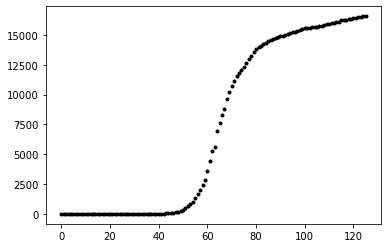

In [4]:
# une classe qui nous aide a acceder aux differentes donnes du COVID
ds = CountryDataset()

# par exemple si on veut le numbre de cas cumulatifs pour un pays:
country_data = ds.cumulative('Austria')
plt.plot(country_data, 'k.')
plt.show()

Maintenant qu'on a les donées on peut commencer par faire un fitting tout simple

In [6]:
rescaling = 10000  # il faut rendre les chiffres plus petits sinon ça ne marche pas

country_data = country_data.reshape(-1, 1)/rescaling # toutes mes methodes s'attendent a des vecteurs colonnes

# on fait les deux matrices
targets, states = country_data[1:], country_data[:-1]

# on augmente l'etat avec des termes polynomiaux
augmented, _ = make_polynomials(states, max_degree=3)

# on execute l'algo
weights, _ = sparse_regression(augmented, targets, cutoff=1e-4)

show_weights(weights)

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |    0        |
| $ x$       |    1.31965  |
| $ x^2$     |   -0.382343 |
| $ x^3$     |    0.115088 |

Maintenant on peut integrer la solution

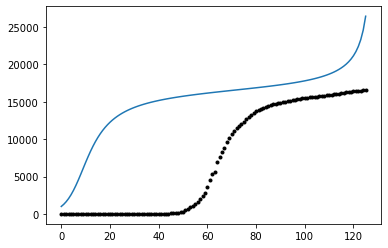

In [9]:
t = range(len(country_data))

guess = integrate(weights, [0.1], t)

plt.plot(country_data*rescaling, 'k.')
plt.plot(guess*rescaling)
plt.show()